In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, lax, jacfwd, jacrev, value_and_grad
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def init_MLP(layers, key, activation=jax.nn.tanh):
    keys = random.split(key, len(layers)-1)
    params = []
    for in_w, out_w, key in zip(layers[:-1], layers[1:], keys):
        w = random.normal(key, (in_w, out_w), dtype=jnp.float32) * jnp.sqrt(2 / (in_w + out_w))
        b = jnp.zeros(out_w, dtype=jnp.float32)
        params.append((w, b))

    def _MLP(params, x):
        for w, b in params[:-1]:
            x = activation(jnp.dot(x, w) + b)
        w, b = params[-1]
        return jnp.dot(x, w) + b

    return params, _MLP


In [3]:
seed = 0
key = random.PRNGKey(seed)
layers = [1, 64, 64, 64, 64, 64, 64, 1]
params, mlp = init_MLP(layers, key)
jax.tree_map(lambda x: x.shape, params)

CUDA backend failed to initialize: Unable to load cuSOLVER. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[((1, 64), (64,)),
 ((64, 64), (64,)),
 ((64, 64), (64,)),
 ((64, 64), (64,)),
 ((64, 64), (64,)),
 ((64, 64), (64,)),
 ((64, 1), (1,))]

In [4]:
laplace_operator = vmap(jacfwd(jacfwd(mlp, argnums=1), argnums=1), in_axes=(None, 0))
forward = vmap(mlp, in_axes=(None, 0))

def loss_boundary(params, x, y):
    u = forward(params, x)
    return jnp.mean((u - y)**2)

def loss_residual(params, x, y):
    laplace = laplace_operator(params, x)[:, 0, 0]
    return jnp.mean((laplace - y)**2)

def loss_total(params, x_colloc, x_bndry, y_colloc, y_bndry):
    return loss_boundary(params, x_bndry, y_bndry) + loss_residual(params, x_colloc, y_colloc)

@jit
def update(params, opt_state, lr, momentum, x_colloc, x_bndry, y_colloc, y_residual):
    loss, grads = value_and_grad(loss_total)(params, x_colloc, x_bndry, y_colloc, y_residual)
    opt_state = jax.tree_map(lambda avg_g, g: momentum * avg_g + (1 - momentum) * g, opt_state, grads)
    new_params = jax.tree_map(lambda p, g: p - lr * g, params, opt_state)
    # print(grads)
    return new_params, opt_state, loss
        

In [5]:
x_colloc = jnp.linspace(0, 1, 1000, dtype=jnp.float32).reshape(-1, 1)
y_colloc = -(jnp.pi * 4.) ** 2 * jnp.sin(jnp.pi * 4. * x_colloc)
u_exact = jnp.sin(jnp.pi * 4. * x_colloc)
x_bndry = jnp.array([0., 1.], dtype=jnp.float32).reshape(-1, 1)
y_bndry = jnp.zeros((2, 1), dtype=jnp.float32)

In [6]:
# jnp.mean((laplace_operator(params, x_colloc)[:, 0, 0] - y_colloc)**2)

In [7]:
g = grad(loss_residual)(params, x_colloc, y_colloc)

In [8]:
g[0][0].shape

(1, 64)

In [10]:
n_epochs = 100000
lr = 1e-4
momentum = 0.99
opt_state = jax.tree_map(lambda x: jnp.zeros_like(x), params)
for epoch in range(n_epochs):
    params, opt_state, loss = update(params, opt_state, lr, momentum, x_colloc, x_bndry, y_colloc, y_bndry)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss:.4f}')
        lr *= 0.95
# for epoch in range(n_epochs):
#     params, loss = update(params, x_colloc, x_bndry, y_colloc, y_bndry)
#     if epoch % 1000 == 0:
#         print(f'Epoch {epoch}, Loss {loss:.4f}')

Epoch 0, Loss 0.0099


KeyboardInterrupt: 

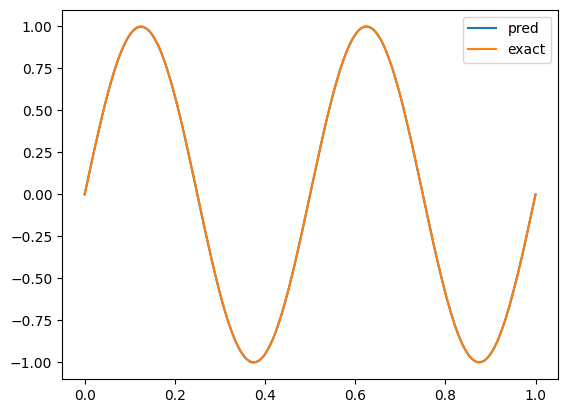

In [ ]:
plt.plot(x_colloc, forward(params, x_colloc), label='pred')
plt.plot(x_colloc, u_exact, label='exact')
plt.legend()